# AutoETS

AutoETS (Auto Exponential Smoothing) is an automatic forecasting method that applies exponential smoothing to time series data with trend and seasonality.

**Key Ideas**  
- Automatically selects the best exponential smoothing model based on information criteria (AIC, AICC or BIC).
- Provides point, variance, quantile, interval and distribution forecasts.
- Can be used with different types of seasonality or no seasonality at all.
- sktime package: provide multiple probabilistic forecasting methods and possible to implement its own custom probabilistic forecaster.

**Model documentation**: 

- github: https://github.com/sktime/sktime
- AutoETS: https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.ets.AutoETS.html
- sktime notebook proba forecasting: https://github.com/sktime/sktime/blob/main/examples/01b_forecasting_proba.ipynb
- user guide: https://www.sktime.net/en/v0.19.2/examples/01b_forecasting_proba.html
- guide to build your own probabilistic forecaster: https://www.sktime.net/en/stable/developer_guide/add_estimators.html

**Requirements:**

!pip install birdgame

!pip install sktime

# Probabilistic Forecasting

Probabilistic forecasting provides **a distribution of possible future values** rather than a single point estimate, allowing for uncertainty quantification. Instead of predicting only the most likely outcome, it estimates a range of potential outcomes along with their probabilities by outputting a **probability distribution**.

A probabilistic forecast models the conditional probability distribution of a future value $(Y_t)$ given past observations $(\mathcal{H}_{t-1})$. This can be expressed as:  

$$P(Y_t \mid \mathcal{H}_{t-1})$$

where $(\mathcal{H}_{t-1})$ represents the historical data up to time $(t-1)$. Instead of a single prediction $(\hat{Y}_t)$, the model estimates a full probability distribution $(f(Y_t \mid \mathcal{H}_{t-1}))$, which can take different parametric forms, such as a Gaussian:

$$Y_t \mid \mathcal{H}_{t-1} \sim \mathcal{N}(\mu_t, \sigma_t^2)$$

where $(\mu_t)$ is the predicted mean and $(\sigma_t^2)$ represents the uncertainty in the forecast.

Probabilistic forecasting can be handled through various approaches, including **variance forecasters**, **quantile forecasters**, **interval forecasters** or **distribution forecasters**, each capturing uncertainty differently.

In this notebook, we try to forecast the target location by a gaussian density function (or a mixture), the model output follows the form:

```python
{"density": {
                "name": "normal",
                "params": {"loc": y_mean, "scale": y_var}
            },
                "weight": weight
}
```

A **mixture density**, such as the gaussion mixture $\sum_{i=1}^{K} w_i \mathcal{N}(Y_t | \mu_i, \sigma_i^2)$ allows for capturing multi-modal distributions and approximate more complex distributions.

![proba_forecast_v3](https://github.com/Tarandro/image_broad/blob/main/proba_forecast_v3.png?raw=true)


**Probabilistic Forecasting** is particularly valuable in supply chain management. Below are some interesting resources for a deeper understanding:  

- [Probabilistic Forecasting](https://www.lokad.com/probabilistic-forecasting-definition/) – Overview of probabilistic forecasting and its applications.  
- [Quantile Forecasting](https://www.lokad.com/quantile-regression-time-series-definition/) – Explanation of quantile-based forecasting methods.  
- **Evaluation Metrics:**  
  - [Continuous Ranked Probability Score (CRPS)](https://www.lokad.com/continuous-ranked-probability-score/)  
  - [Cross-Entropy](https://www.lokad.com/cross-entropy-definition/)  
  - [Pinball Loss](https://www.lokad.com/pinball-loss-function-definition/)

In [1]:
# Standard library imports
# !pip install birdgame
# !pip install sktime
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm

try:
    from birdgame.trackers.trackerbase import TrackerBase
except:
    # Trick to be on root directory (to remove in the future and use install birdgame)
    # Change the working directory to the root of the package
    root_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
    os.chdir(root_dir)
    
# Birdgame package imports
from birdgame.trackers.trackerbase import TrackerBase
from birdgame.visualization.viz_autoets import visualize_sktime_model

### Warm up example: AutoETS

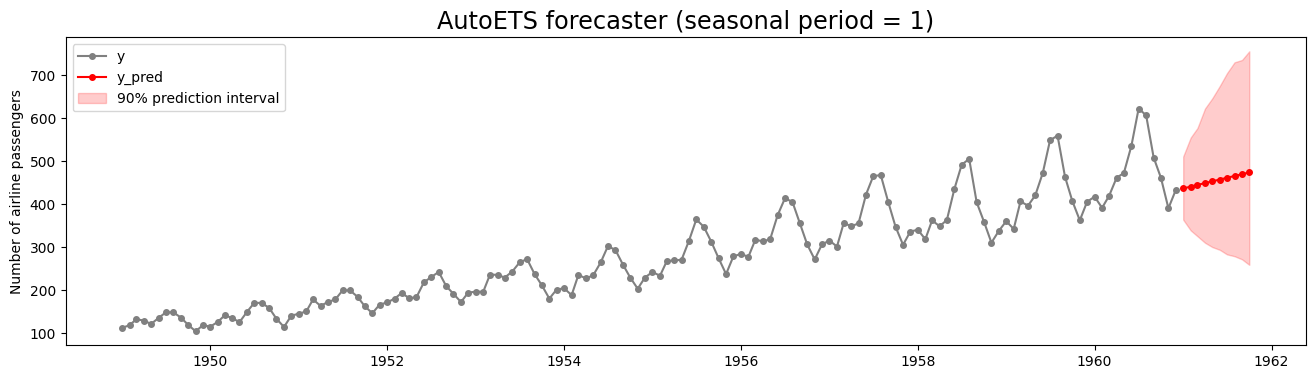

Variance estimation:


,Number of airline passengers
1961-01,1951.783409
1961-02,3960.517860
1961-03,5965.456816
1961-04,7889.697318
1961-05,11232.466362
1961-06,13187.125583
1961-07,15612.707950
1961-08,17479.581487
1961-09,20362.173417
1961-10,24569.615848


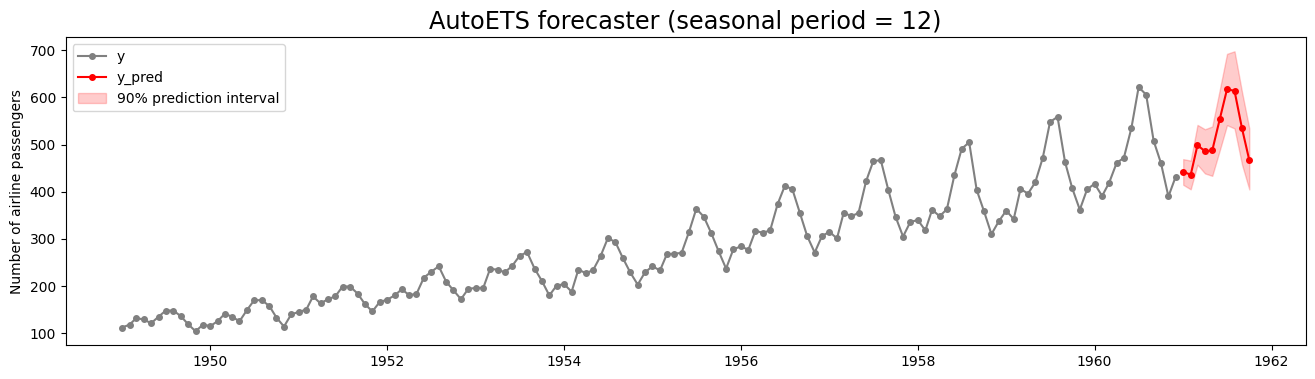

Variance estimation:


,Number of airline passengers
1961-01,249.716345
1961-02,337.625538
1961-03,644.564883
1961-04,741.480848
1961-05,943.589902
1961-06,1371.492311
1961-07,1957.275330
1961-08,2271.650886
1961-09,1933.512865
1961-10,1645.253599


In [2]:
# Run AutoETS sktime model for different seasonal period
for sp in [1, 12]:
    visualize_sktime_model(seasonal_period=sp)

In [3]:
import numpy as np
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.base import ForecastingHorizon
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sktime.forecasting.arima import AutoARIMA

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")
    

class AutoETSsktimeTracker(TrackerBase):
    """
    A model that tracks the dove location using AutoETS.

    Parameters
    ----------
    horizon : int
        The number of time steps into the future that predictions should be made for.
    train_model_frequency : int
        The frequency at which the sktime model will be retrained based on the count of observations 
        ingested. This determines how often the model will be updated with new data.
    num_data_points_max : int
        The maximum number of data points to use for training the sktime model.
    """

    def __init__(self):
        super().__init__(Constants.HORIZON)
        self.current_x = None
        self.last_observed_data = [] # Holds the last few observed data points
        self.prev_t = 0

        self.train_model_frequency = Constants.TRAIN_MODEL_FREQUENCY
        self.num_data_points_max = Constants.NUM_DATA_POINTS_MAX

        # Number of steps to predict
        steps = 1 # only one because the univariate serie will only have values separated of at least HORIZON time
        self.fh = np.arange(1, steps + 1)

        # Fit the AutoETS forecaster (no seasonality)
        self.forecaster = AutoETS(auto=True, sp=1, information_criterion="aic")

        # or Fit the AutoARIMA forecaster
        # self.forecaster = AutoARIMA(max_p=2, max_d=1, max_q=2, maxiter=10)
        
    def tick(self, payload):
        """
        Ingest a new record (payload), store it internally and update the model.

        Parameters
        ----------
        payload : dict
            Must contain 'time' (int/float) and 'dove_location' (float).
        """
        x = payload['dove_location']
        t = payload['time']
        self.add_to_quarantine(t, x)
        self.current_x = x

        # we build a univariate serie of values separated of at least HORIZON time
        if t > self.prev_t + self.horizon:
            self.last_observed_data.append(x)
            self.prev_t = t

        prev_x = self.pop_from_quarantine(t)

        if prev_x is not None:

            if self.count > 10 and self.count%self.train_model_frequency == 0:
                # Construct 'y' as an univariate serie
                y = np.array(self.last_observed_data)[-self.num_data_points_max:]

                # Fit sktime model
                self.forecaster.fit(y, fh=self.fh)

                # Variance prediction
                var = self.forecaster.predict_var(fh=self.fh)
                self.scale = np.sqrt(var.values.flatten()[-1])

                # Update last observed data (to limit memory usage as it will be run on continuous live data)
                self.last_observed_data = self.last_observed_data[-(self.num_data_points_max + 2):]
            self.count += 1

    def predict(self):
        """
        Return a dictionary representing the best guess of the distribution,
        modeled as a Gaussian distribution.
        """
        # the central value (mean) of the gaussian distribution will be represented by the current value
        x_mean = self.current_x
        components = []

        try:
            # here we use current value as loc but you can get point forecast from 'self.forecaster.predict(fh=self.fh[-1])[0][0]'
            loc = x_mean

            # we predicted scale during tick training
            scale = self.scale
            scale = max(scale, 1e-6)

            # If you want to predict variance for each prediction
            # scale = self.forecaster.predict_var(fh=self.fh)
            # scale = np.sqrt(scale.values.flatten()[-1])
        except:
            loc = x_mean
            scale = 1e-6

        # Return the prediction density
        components = {
            "density": {
                "type": "builtin",
                "name": "norm",
                "params": {"loc": loc, "scale": scale}
            },
            "weight": 1
        }

        prediction_density = {
            "type": "mixture",
            "components": [components]
        }

        return prediction_density

### Tracker experimentation

The model is experimented on a data generator using the [density_pdf](https://github.com/microprediction/densitypdf/blob/main/densitypdf/__init__.py) scoring. For a gaussian distribution, it is:

$$\text{pdf\_score}(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(x - \mu)^2}{2\sigma^2}}$$

This metric measures how well the predicted distribution aligns with the observed data. **A higher pdf_score indicates a more accurate prediction.**

In [4]:
# Parameters
class Constants:
    HORIZON = 10
    TRAIN_MODEL_FREQUENCY=50
    NUM_DATA_POINTS_MAX=20

### Run on a remote static data file

In [5]:
# Initialize Tracker
tracker = AutoETSsktimeTracker()

# Run on remote data
tracker.test_run(live=False)

0it [00:00, ?it/s]

My likelihood score: 0.3414 VS Benchmark likelihood score: 2.5298
     .... and mine is worse. Ratio is 0.13493
My likelihood score: 0.5475 VS Benchmark likelihood score: 2.4641
     .... and mine is worse. Ratio is 0.22219
My likelihood score: 0.9891 VS Benchmark likelihood score: 2.4350
     .... and mine is worse. Ratio is 0.40621
My likelihood score: 1.2032 VS Benchmark likelihood score: 2.5580
     .... and mine is worse. Ratio is 0.47035
My likelihood score: 1.3506 VS Benchmark likelihood score: 2.6113
     .... and mine is worse. Ratio is 0.51720
My likelihood score: 1.4711 VS Benchmark likelihood score: 2.6678
     .... and mine is worse. Ratio is 0.55142
My likelihood score: 1.4954 VS Benchmark likelihood score: 2.5774
     .... and mine is worse. Ratio is 0.58019
My likelihood score: 1.4541 VS Benchmark likelihood score: 2.4989
     .... and mine is worse. Ratio is 0.58189
My likelihood score: 1.4073 VS Benchmark likelihood score: 2.4731
     .... and mine is worse. Ratio is 

### Run on live data

In [6]:
# Initialize Tracker
tracker = AutoETSsktimeTracker()

# Run on live data
tracker.test_run(live=True)

0it [00:00, ?it/s]

My likelihood score: 2.5349 VS Benchmark likelihood score: 4.0443
     .... and mine is worse. Ratio is 0.62679
My likelihood score: 3.3488 VS Benchmark likelihood score: 4.5614
     .... and mine is worse. Ratio is 0.73416
My likelihood score: 3.7421 VS Benchmark likelihood score: 4.7052
     .... and mine is worse. Ratio is 0.79531
My likelihood score: 3.9308 VS Benchmark likelihood score: 4.7809
     .... and mine is worse. Ratio is 0.82220
My likelihood score: 3.8825 VS Benchmark likelihood score: 4.7817
     .... and mine is worse. Ratio is 0.81194
Interrupted


### An animated run

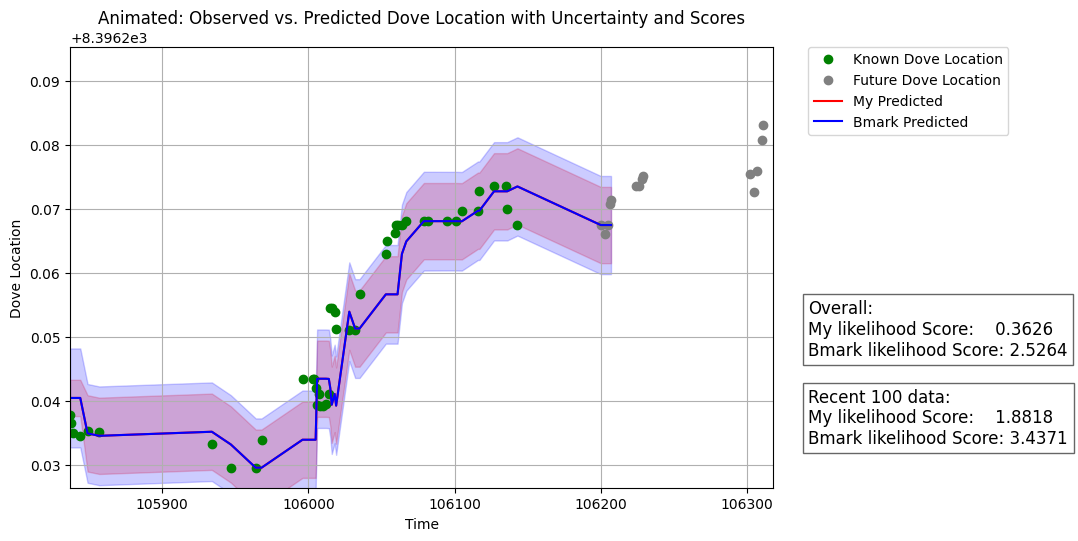

KeyboardInterrupt: 

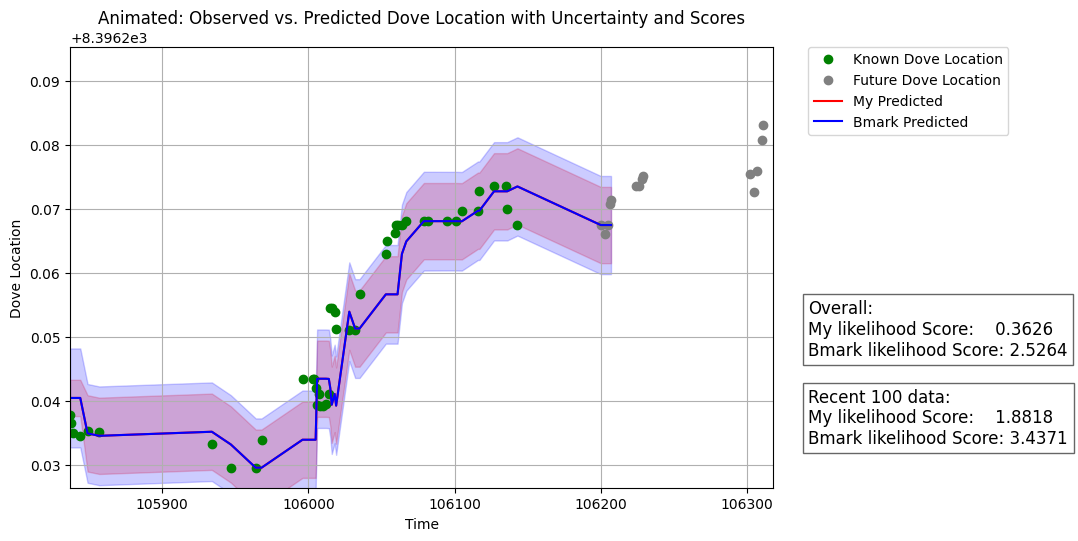

In [7]:
%matplotlib inline
from IPython.display import HTML

tracker = AutoETSsktimeTracker()

animated = tracker.test_run_animated(live=False, from_notebook=True)

# Display animation in notebook
HTML(animated.to_jshtml())

# Interrupt cell to stop run

### Design your own testing process and statistical analysis

In [8]:
from birdgame.model_benchmark.emwavartracker import EMWAVarTracker
from birdgame.trackers.tracker_evaluator import TrackerEvaluator
from birdgame.datasources.livedata import live_data_generator
from birdgame.datasources.remotetestdata import remote_test_data_generator
from birdgame.visualization.utils import get_loc_and_scale


live = False
step_print = 1000
warmup_iterations = 300
max_iterations = 10000

tracker = AutoETSsktimeTracker()

benchmark_tracker = EMWAVarTracker(horizon=tracker.horizon)
my_run, bmark_run = TrackerEvaluator(tracker), TrackerEvaluator(benchmark_tracker)

gen = live_data_generator() if live else remote_test_data_generator()

store_pred = []
try:
    for i, payload in enumerate(tqdm(gen)):

        my_run.tick_and_predict(payload)
        bmark_run.tick_and_predict(payload)

        if i > warmup_iterations:
            score = my_run.scores[-1]
            
            loc, scale = get_loc_and_scale(my_run.latest_valid_prediction)
            store_pred.append({
                "time": my_run.time,
                "prediction": my_run.latest_valid_prediction,
                "loc": loc,
                "scale": scale,
                "dove_location": my_run.dove_location,
                "score": score,
                "log_score": np.log(1e-10 + score)
            })

        if (i + 1) % step_print == 0:
            print(f"My likelihood score: {my_run.overall_likelihood_score():.4f} VS Benchmark likelihood score: {bmark_run.overall_likelihood_score():.4f}")

        if i > max_iterations:
            break

    print(f"My likelihood score: {my_run.overall_likelihood_score():.4f} VS Benchmark likelihood score: {bmark_run.overall_likelihood_score():.4f}")
except KeyboardInterrupt:
    print("Interrupted")

0it [00:00, ?it/s]

My likelihood score: 0.3384 VS Benchmark likelihood score: 2.5298
My likelihood score: 0.5428 VS Benchmark likelihood score: 2.4641
My likelihood score: 0.9917 VS Benchmark likelihood score: 2.4350
My likelihood score: 1.1986 VS Benchmark likelihood score: 2.5580
My likelihood score: 1.3586 VS Benchmark likelihood score: 2.6113
My likelihood score: 1.4781 VS Benchmark likelihood score: 2.6678
My likelihood score: 1.5027 VS Benchmark likelihood score: 2.5774
My likelihood score: 1.4528 VS Benchmark likelihood score: 2.4989
My likelihood score: 1.4131 VS Benchmark likelihood score: 2.4731
My likelihood score: 1.3769 VS Benchmark likelihood score: 2.4504
My likelihood score: 1.3773 VS Benchmark likelihood score: 2.4505


In [10]:
from birdgame.visualization.utils import summarize_predictions
stats_summary, pred_summary = summarize_predictions(store_pred, skip_length=0)

Mean: {'score': 25.095, 'log_score': 1.476}
Median: {'score': 18.17, 'log_score': 2.9}
Std: {'score': 26.719, 'log_score': 5.217}

Prediction Data:


,time,prediction,loc,scale,dove_location,score,log_score
0,99131.0,"{'type': 'mixture', 'components': [{'density':...",8396.23484,0.00653,8396.20651,0.00495,-5.30858
1,99134.0,"{'type': 'mixture', 'components': [{'density':...",8396.23484,0.00653,8396.20660,0.00527,-5.24625
2,99135.0,"{'type': 'mixture', 'components': [{'density':...",8396.22911,0.00653,8396.21083,1.21038,0.19093
3,99136.0,"{'type': 'mixture', 'components': [{'density':...",8396.22642,0.00653,8396.21608,17.44052,2.85880
4,99141.0,"{'type': 'mixture', 'components': [{'density':...",8396.20651,0.00653,8396.21939,8.72615,2.16632
...,...,...,...,...,...,...,...
9696,187939.0,"{'type': 'mixture', 'components': [{'density':...",8395.18560,0.00527,8395.19369,23.31784,3.14922
9697,187949.0,"{'type': 'mixture', 'components': [{'density':...",8395.19369,0.00527,8395.19147,69.19939,4.23699
9698,187950.0,"{'type': 'mixture', 'components': [{'density':...",8395.19369,0.00527,8395.18889,50.02097,3.91244
9699,187953.0,"{'type': 'mixture', 'components': [{'density':...",8395.19369,0.00527,8395.18732,36.45698,3.59613


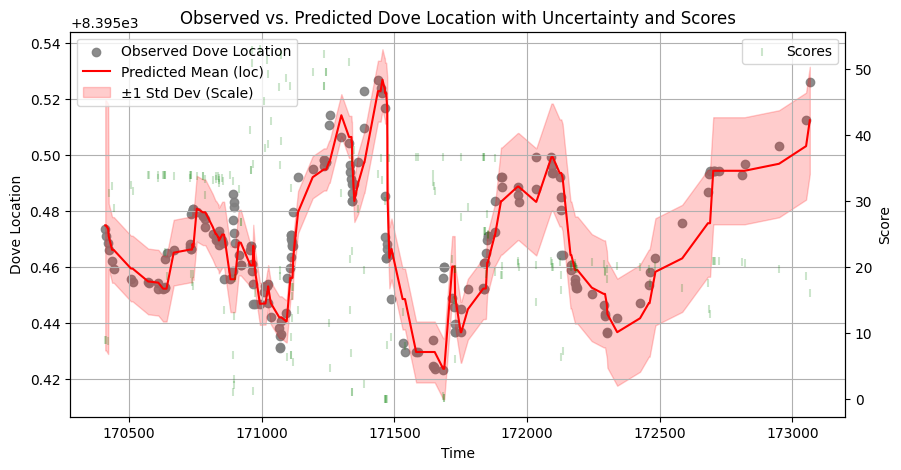

In [11]:
from birdgame.visualization.viz_predictions import plot_dove_predictions
start_ind=8000
window_size=200
plot_dove_predictions(store_pred, start_ind, window_size)